In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [2]:
data_set = datasets.CIFAR10(root="./data", download=False, transform=transforms.Compose(
    [transforms.Resize(64),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))
data_loader = torch.utils.data.DataLoader(data_set, batch_size = 128, shuffle=True, num_workers=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(3,64,4,2,1,bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(64,128,4,2,1,bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(128,256,4,2,1,bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(256,512,4,2,1,bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,True)
        )
        
        self.verify = nn.Sequential(
            nn.Conv2d(512, 1, 4, 1, 0, bias = False), 
            nn.Sigmoid()
        )
        
        self.labels = nn.Sequential(
            nn.Conv2d(512, 11, 4, 1, 0, bias = False), 
            nn.LogSoftmax(dim = 1)
        )
        
    def forward(self, passed_input):
        passed_input = self.main(passed_input)
        validity = self.verify(passed_input)
        output_labels = self.labels(passed_input)
        
        # resize
        validity = validity.view(-1)
        output_labels = output_labels.view(-1,11)
        return validity, output_labels

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        self.emb = nn.Embedding(10,100)
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100,512,4,1,0,bias = False),
            nn.ReLU(True),
            nn.ConvTranspose2d(512,256,4,2,1,bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256,128,4,2,1,bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,64,4,2,1,bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64,3,4,2,1,bias = False),
            nn.Tanh()
        )
        
    def forward(self, noise, inputLabels):
        embLabels = self.emb(inputLabels)
        temp = torch.mul(noise, embLabels)
        temp = temp.view(-1, 100, 1, 1)
        return self.main(temp)

In [6]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
discriminator.apply(weights_init)
generator.apply(weights_init)

Generator(
  (emb): Embedding(10, 100)
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): Tanh()
  )
)

In [7]:
dis_optim = optim.Adam(discriminator.parameters(), 0.0002, betas = (0.5,0.999))
gen_optim = optim.Adam(generator.parameters(), 0.0002, betas = (0.5,0.999))
criterion = nn.BCELoss()


num_epochs = 10
real_labels_tensor = 0.7 + 0.5 * torch.rand(10, device = device)
fake_labels_tensor = 0.3 * torch.rand(10, device = device)


counter_list = []
counter = 0
gen_loss_list = []
dis_loss_list = []

In [8]:
for epoch in range(0, num_epochs):
    
    # Iterate through all batches
    for index, (data, image_labels) in enumerate(data_loader, 0):
        counter += 1
        counter_list.append(counter)
        
        # make data avaialbe for cuda
        data = data.to(device)
        image_labels = image_labels.to(device)
        size_of_batch = data.size(0)
        labels_real = real_labels_tensor[index % 10]
        labels_fake = fake_labels_tensor[index % 10]
        class_labels_fake = 10 * torch.ones((size_of_batch, ), dtype = torch.long, device = device)
        
        # Periodically switch labels
        if index % 25 == 0:
            temp = labels_real
            labels_real = labels_fake
            labels_fake = temp
        
        # Train Discriminator with real data
        labels_for_validate = torch.full((size_of_batch, ), labels_real, device = device)
        dis_optim.zero_grad() 
        validity, output_labels = discriminator(data)       
        dis_real_valid_error = criterion(validity, labels_for_validate)            
        dis_real_label_error = F.nll_loss(output_labels, image_labels)
        dis_real_error = dis_real_valid_error + dis_real_label_error
        dis_real_error.backward()
        valid_mean1 = validity.mean().item()        
        
        # Train Discriminator with fake data
        dis_fake_labels = torch.randint(0, 10, (size_of_batch, ), dtype = torch.long, device = device)
        noise = torch.randn(size_of_batch, 100, device = device)  
        labels_for_validate.fill_(labels_fake)
        fake_output = generator(noise, dis_fake_labels)
        validity, output_labels = discriminator(fake_output.detach())       
        dis_fake_valid_error = criterion(validity, labels_for_validate)
        dis_fake_label_error = F.nll_loss(output_labels, class_labels_fake)
        dis_fake_error = dis_fake_valid_error + dis_fake_label_error
        dis_fake_error.backward()
        final_dis_error = dis_real_error + dis_fake_error
        valid_mean2 = validity.mean().item()
        dis_optim.step()
    
        # Train Generator
        labels_for_validate.fill_(1)
        labels_for_gen = torch.randint(0, 10, (size_of_batch, ), device = device, dtype = torch.long)
        noise = torch.randn(size_of_batch, 100, device = device)  
        gen_optim .zero_grad()
        fake_output = generator(noise, labels_for_gen)
        validity, output_labels = discriminator(fake_output)
        gen_valid_error = criterion(validity, labels_for_validate)        
        gen_label_error = F.nll_loss(output_labels, labels_for_gen)
        final_gen_error = gen_valid_error + gen_label_error
        final_gen_error.backward()
        valid_mean3 = validity.mean().item()
        gen_optim .step()
        
        
        print("[{}/{}] [{}/{}] D(x): [{:.4f}] D(G): [{:.4f}/{:.4f}] GLoss: [{:.4f}] DLoss: [{:.4f}] DLabel: [{:.4f}] "
              .format(epoch, num_epochs, index, len(data_loader), valid_mean1, valid_mean2, valid_mean3, final_gen_error, final_dis_error,
                      dis_real_label_error+ dis_fake_label_error + gen_label_error))
        
        # Save errors for graphing
        dis_loss_list.append(final_dis_error.cpu().detach().numpy())
        gen_loss_list.append(final_gen_error.cpu().detach().numpy())
        
    # Save images to folder
    labels = torch.arange(0,10,dtype = torch.long,device = device)
    noise = torch.randn(10,100,device = device)  
    images = generator(noise, labels)
    vutils.save_image(images.detach(),'ACGANOutput/fake_samples_epoch_%03d.png' % (epoch), normalize = True)

[0/10] [0/391] D(x): [0.6102] D(G): [0.5687/0.5825] GLoss: [6.9520] DLoss: [8.7356] DLabel: [13.3483] 
[0/10] [1/391] D(x): [0.3687] D(G): [0.8276/0.3194] GLoss: [8.8558] DLoss: [7.1621] DLabel: [12.0191] 
[0/10] [2/391] D(x): [0.2434] D(G): [0.5602/0.3200] GLoss: [8.1213] DLoss: [6.4106] DLabel: [10.6440] 
[0/10] [3/391] D(x): [0.4567] D(G): [0.5556/0.0620] GLoss: [9.5607] DLoss: [6.0146] DLabel: [10.4769] 
[0/10] [4/391] D(x): [0.5107] D(G): [0.3523/0.1463] GLoss: [9.6113] DLoss: [5.2975] DLabel: [11.1698] 
[0/10] [5/391] D(x): [0.7279] D(G): [0.6907/0.0808] GLoss: [10.5651] DLoss: [5.4024] DLabel: [11.1172] 
[0/10] [6/391] D(x): [0.6259] D(G): [0.5651/0.0298] GLoss: [12.0229] DLoss: [5.3230] DLabel: [11.5379] 
[0/10] [7/391] D(x): [0.5270] D(G): [0.3390/0.0422] GLoss: [12.2444] DLoss: [4.9808] DLabel: [12.2256] 
[0/10] [8/391] D(x): [0.6040] D(G): [0.5262/0.0148] GLoss: [13.2443] DLoss: [4.7888] DLabel: [11.6156] 
[0/10] [9/391] D(x): [0.6442] D(G): [0.3782/0.0503] GLoss: [12.8343] 

[0/10] [79/391] D(x): [0.7084] D(G): [0.0793/0.1888] GLoss: [7.4668] DLoss: [3.1395] DLabel: [7.4999] 
[0/10] [80/391] D(x): [0.8729] D(G): [0.4678/0.1247] GLoss: [11.4330] DLoss: [3.7842] DLabel: [11.6598] 
[0/10] [81/391] D(x): [0.8090] D(G): [0.3187/0.0621] GLoss: [12.5377] DLoss: [2.9865] DLabel: [11.3560] 
[0/10] [82/391] D(x): [0.6532] D(G): [0.2124/0.2047] GLoss: [8.3836] DLoss: [2.9967] DLabel: [8.7021] 
[0/10] [83/391] D(x): [0.8300] D(G): [0.5153/0.0050] GLoss: [16.5242] DLoss: [3.6379] DLabel: [13.1563] 
[0/10] [84/391] D(x): [0.5841] D(G): [0.0235/0.0307] GLoss: [12.4385] DLoss: [3.1483] DLabel: [10.6334] 
[0/10] [85/391] D(x): [0.8118] D(G): [0.1401/0.2210] GLoss: [8.2172] DLoss: [2.9396] DLabel: [8.4693] 
[0/10] [86/391] D(x): [0.8443] D(G): [0.5739/0.0094] GLoss: [17.1277] DLoss: [3.5634] DLabel: [14.3834] 
[0/10] [87/391] D(x): [0.6281] D(G): [0.0443/0.0588] GLoss: [12.6848] DLoss: [2.6702] DLabel: [11.3318] 
[0/10] [88/391] D(x): [0.8159] D(G): [0.2157/0.0657] GLoss: [

[0/10] [158/391] D(x): [0.8266] D(G): [0.1813/0.0631] GLoss: [10.1551] DLoss: [2.2624] DLabel: [8.7737] 
[0/10] [159/391] D(x): [0.8097] D(G): [0.1279/0.2062] GLoss: [8.4965] DLoss: [2.7903] DLabel: [8.4766] 
[0/10] [160/391] D(x): [0.8583] D(G): [0.3349/0.1708] GLoss: [9.1679] DLoss: [2.9352] DLabel: [9.0524] 
[0/10] [161/391] D(x): [0.7949] D(G): [0.2880/0.1230] GLoss: [10.1053] DLoss: [3.0224] DLabel: [9.7446] 
[0/10] [162/391] D(x): [0.6899] D(G): [0.2067/0.2797] GLoss: [7.5446] DLoss: [2.7629] DLabel: [8.0380] 
[0/10] [163/391] D(x): [0.7952] D(G): [0.4411/0.0128] GLoss: [14.2882] DLoss: [3.0165] DLabel: [11.5517] 
[0/10] [164/391] D(x): [0.5330] D(G): [0.0250/0.0752] GLoss: [9.9067] DLoss: [3.2383] DLabel: [9.0033] 
[0/10] [165/391] D(x): [0.8111] D(G): [0.1343/0.2388] GLoss: [7.5128] DLoss: [2.8023] DLabel: [7.7412] 
[0/10] [166/391] D(x): [0.8806] D(G): [0.3950/0.0493] GLoss: [13.4062] DLoss: [2.8707] DLabel: [12.0550] 
[0/10] [167/391] D(x): [0.7428] D(G): [0.0908/0.1047] GLos

[0/10] [237/391] D(x): [0.8234] D(G): [0.3657/0.1021] GLoss: [9.9723] DLoss: [2.2327] DLabel: [9.2922] 
[0/10] [238/391] D(x): [0.7994] D(G): [0.2150/0.0566] GLoss: [11.4438] DLoss: [2.2135] DLabel: [9.9359] 
[0/10] [239/391] D(x): [0.7252] D(G): [0.1238/0.2716] GLoss: [6.2599] DLoss: [3.0936] DLabel: [6.8065] 
[0/10] [240/391] D(x): [0.8827] D(G): [0.4467/0.1033] GLoss: [13.1711] DLoss: [3.2099] DLabel: [12.6374] 
[0/10] [241/391] D(x): [0.6158] D(G): [0.1729/0.2717] GLoss: [7.3059] DLoss: [3.9939] DLabel: [8.7647] 
[0/10] [242/391] D(x): [0.8331] D(G): [0.4081/0.2126] GLoss: [7.1876] DLoss: [2.5669] DLabel: [7.3197] 
[0/10] [243/391] D(x): [0.8442] D(G): [0.3595/0.0174] GLoss: [15.9663] DLoss: [3.0029] DLabel: [13.6220] 
[0/10] [244/391] D(x): [0.4705] D(G): [0.0329/0.1178] GLoss: [10.3567] DLoss: [3.7264] DLabel: [10.3815] 
[0/10] [245/391] D(x): [0.7863] D(G): [0.2063/0.2868] GLoss: [7.6011] DLoss: [2.8385] DLabel: [8.0668] 
[0/10] [246/391] D(x): [0.8770] D(G): [0.4161/0.1025] GLo

[0/10] [316/391] D(x): [0.8035] D(G): [0.2860/0.0935] GLoss: [10.8724] DLoss: [2.6306] DLabel: [10.0728] 
[0/10] [317/391] D(x): [0.7458] D(G): [0.1968/0.1487] GLoss: [8.0747] DLoss: [2.1588] DLabel: [7.6990] 
[0/10] [318/391] D(x): [0.8330] D(G): [0.2768/0.0428] GLoss: [11.7863] DLoss: [2.4659] DLabel: [10.1783] 
[0/10] [319/391] D(x): [0.7997] D(G): [0.0902/0.1938] GLoss: [8.2811] DLoss: [2.7314] DLabel: [8.0591] 
[0/10] [320/391] D(x): [0.8179] D(G): [0.3339/0.1874] GLoss: [8.8618] DLoss: [2.7467] DLabel: [8.7054] 
[0/10] [321/391] D(x): [0.8394] D(G): [0.3257/0.0725] GLoss: [12.1424] DLoss: [2.9471] DLabel: [11.1157] 
[0/10] [322/391] D(x): [0.7205] D(G): [0.1289/0.3707] GLoss: [6.4074] DLoss: [2.4214] DLabel: [6.8758] 
[0/10] [323/391] D(x): [0.8386] D(G): [0.5341/0.0065] GLoss: [19.6954] DLoss: [3.4445] DLabel: [16.4522] 
[0/10] [324/391] D(x): [0.3359] D(G): [0.0111/0.1560] GLoss: [8.1318] DLoss: [6.0820] DLabel: [10.0746] 
[0/10] [325/391] D(x): [0.8450] D(G): [0.2543/0.7569] G

[1/10] [4/391] D(x): [0.3944] D(G): [0.1021/0.3804] GLoss: [5.2481] DLoss: [3.5066] DLabel: [6.2389] 
[1/10] [5/391] D(x): [0.7902] D(G): [0.4303/0.2826] GLoss: [7.8056] DLoss: [3.1414] DLabel: [8.4321] 
[1/10] [6/391] D(x): [0.7943] D(G): [0.3634/0.1224] GLoss: [10.5963] DLoss: [2.6954] DLabel: [10.0530] 
[1/10] [7/391] D(x): [0.6385] D(G): [0.1684/0.2596] GLoss: [7.2254] DLoss: [2.5907] DLabel: [7.6459] 
[1/10] [8/391] D(x): [0.8814] D(G): [0.3952/0.1079] GLoss: [10.2433] DLoss: [2.5190] DLabel: [9.4116] 
[1/10] [9/391] D(x): [0.6950] D(G): [0.1579/0.1903] GLoss: [8.2094] DLoss: [2.8454] DLabel: [8.0978] 
[1/10] [10/391] D(x): [0.8225] D(G): [0.2758/0.1970] GLoss: [8.7205] DLoss: [2.6636] DLabel: [8.5041] 
[1/10] [11/391] D(x): [0.7481] D(G): [0.2731/0.1481] GLoss: [9.4331] DLoss: [2.6976] DLabel: [8.9662] 
[1/10] [12/391] D(x): [0.7340] D(G): [0.2379/0.3001] GLoss: [7.2040] DLoss: [2.4278] DLabel: [7.4944] 
[1/10] [13/391] D(x): [0.8291] D(G): [0.3981/0.0435] GLoss: [12.2520] DLoss:

[1/10] [84/391] D(x): [0.5054] D(G): [0.1541/0.3325] GLoss: [5.3802] DLoss: [3.1524] DLabel: [6.1475] 
[1/10] [85/391] D(x): [0.8039] D(G): [0.4765/0.1421] GLoss: [9.8078] DLoss: [3.8890] DLabel: [10.4227] 
[1/10] [86/391] D(x): [0.5927] D(G): [0.2510/0.3021] GLoss: [6.1822] DLoss: [3.6135] DLabel: [7.4090] 
[1/10] [87/391] D(x): [0.7294] D(G): [0.4539/0.2127] GLoss: [7.8832] DLoss: [3.1558] DLabel: [8.5227] 
[1/10] [88/391] D(x): [0.7120] D(G): [0.4628/0.1133] GLoss: [9.4856] DLoss: [3.1311] DLabel: [9.1848] 
[1/10] [89/391] D(x): [0.5206] D(G): [0.2495/0.3684] GLoss: [4.7523] DLoss: [3.7411] DLabel: [6.1026] 
[1/10] [90/391] D(x): [0.7608] D(G): [0.5957/0.1220] GLoss: [10.5206] DLoss: [4.3182] DLabel: [11.2220] 
[1/10] [91/391] D(x): [0.4510] D(G): [0.2396/0.4629] GLoss: [3.8626] DLoss: [4.9801] DLabel: [6.7220] 
[1/10] [92/391] D(x): [0.7121] D(G): [0.5701/0.1861] GLoss: [9.1577] DLoss: [4.3150] DLabel: [10.5451] 
[1/10] [93/391] D(x): [0.6278] D(G): [0.2771/0.1064] GLoss: [10.0861]

[1/10] [163/391] D(x): [0.7531] D(G): [0.3985/0.1458] GLoss: [7.8764] DLoss: [2.5989] DLabel: [7.3154] 
[1/10] [164/391] D(x): [0.6527] D(G): [0.2155/0.1961] GLoss: [7.1440] DLoss: [2.4536] DLabel: [6.9956] 
[1/10] [165/391] D(x): [0.7917] D(G): [0.3002/0.1716] GLoss: [8.3918] DLoss: [2.6455] DLabel: [8.1132] 
[1/10] [166/391] D(x): [0.6939] D(G): [0.2765/0.2033] GLoss: [7.3857] DLoss: [2.7919] DLabel: [7.4993] 
[1/10] [167/391] D(x): [0.7814] D(G): [0.3437/0.1046] GLoss: [9.9981] DLoss: [2.2012] DLabel: [9.2168] 
[1/10] [168/391] D(x): [0.6837] D(G): [0.1899/0.1848] GLoss: [7.0061] DLoss: [2.5252] DLabel: [6.9509] 
[1/10] [169/391] D(x): [0.8239] D(G): [0.3281/0.1083] GLoss: [10.7637] DLoss: [2.6338] DLabel: [9.9983] 
[1/10] [170/391] D(x): [0.7589] D(G): [0.2660/0.2649] GLoss: [7.4291] DLoss: [2.6310] DLabel: [7.4968] 
[1/10] [171/391] D(x): [0.7523] D(G): [0.4347/0.1451] GLoss: [7.9088] DLoss: [2.9074] DLabel: [7.4957] 
[1/10] [172/391] D(x): [0.6079] D(G): [0.2862/0.2671] GLoss: [6

[1/10] [242/391] D(x): [0.4969] D(G): [0.2053/0.5110] GLoss: [3.9912] DLoss: [3.0645] DLabel: [5.0353] 
[1/10] [243/391] D(x): [0.8016] D(G): [0.5716/0.0718] GLoss: [10.8005] DLoss: [3.5648] DLabel: [10.1278] 
[1/10] [244/391] D(x): [0.4379] D(G): [0.1511/0.3328] GLoss: [5.3073] DLoss: [3.6344] DLabel: [6.3890] 
[1/10] [245/391] D(x): [0.8026] D(G): [0.5285/0.1306] GLoss: [9.3943] DLoss: [3.6940] DLabel: [9.6027] 
[1/10] [246/391] D(x): [0.6276] D(G): [0.2280/0.1882] GLoss: [7.2140] DLoss: [2.8640] DLabel: [7.2607] 
[1/10] [247/391] D(x): [0.6733] D(G): [0.3311/0.3080] GLoss: [5.8529] DLoss: [2.7369] DLabel: [6.4701] 
[1/10] [248/391] D(x): [0.8005] D(G): [0.5107/0.1159] GLoss: [9.3148] DLoss: [3.1942] DLabel: [9.0137] 
[1/10] [249/391] D(x): [0.5427] D(G): [0.2414/0.3183] GLoss: [4.9920] DLoss: [3.8794] DLabel: [6.3410] 
[1/10] [250/391] D(x): [0.7136] D(G): [0.5777/0.2537] GLoss: [8.3226] DLoss: [4.6552] DLabel: [9.7293] 
[1/10] [251/391] D(x): [0.5309] D(G): [0.4286/0.3849] GLoss: [

[1/10] [321/391] D(x): [0.6816] D(G): [0.4403/0.1687] GLoss: [7.1018] DLoss: [3.1349] DLabel: [7.0534] 
[1/10] [322/391] D(x): [0.4854] D(G): [0.2642/0.4579] GLoss: [3.5079] DLoss: [3.3760] DLabel: [4.7585] 
[1/10] [323/391] D(x): [0.7841] D(G): [0.5972/0.0929] GLoss: [9.2127] DLoss: [4.0025] DLabel: [9.2131] 
[1/10] [324/391] D(x): [0.3971] D(G): [0.1392/0.3829] GLoss: [4.3540] DLoss: [4.1797] DLabel: [6.0095] 
[1/10] [325/391] D(x): [0.7811] D(G): [0.5197/0.2802] GLoss: [6.9353] DLoss: [4.6072] DLabel: [8.1143] 
[1/10] [326/391] D(x): [0.6485] D(G): [0.3847/0.2526] GLoss: [6.6345] DLoss: [2.8640] DLabel: [6.8786] 
[1/10] [327/391] D(x): [0.6628] D(G): [0.3827/0.3756] GLoss: [4.8786] DLoss: [2.5618] DLabel: [5.5167] 
[1/10] [328/391] D(x): [0.7449] D(G): [0.4440/0.1619] GLoss: [7.7549] DLoss: [2.7941] DLabel: [7.5577] 
[1/10] [329/391] D(x): [0.5349] D(G): [0.2680/0.3813] GLoss: [4.1881] DLoss: [3.0695] DLabel: [4.9458] 
[1/10] [330/391] D(x): [0.7292] D(G): [0.4892/0.2214] GLoss: [7.

[2/10] [9/391] D(x): [0.6474] D(G): [0.3376/0.3175] GLoss: [4.8006] DLoss: [2.9571] DLabel: [5.3721] 
[2/10] [10/391] D(x): [0.7498] D(G): [0.3927/0.2258] GLoss: [6.4283] DLoss: [2.8522] DLabel: [6.5344] 
[2/10] [11/391] D(x): [0.5555] D(G): [0.3423/0.4073] GLoss: [3.3524] DLoss: [3.2930] DLabel: [4.4592] 
[2/10] [12/391] D(x): [0.7606] D(G): [0.5111/0.1423] GLoss: [9.0341] DLoss: [3.5550] DLabel: [9.5298] 
[2/10] [13/391] D(x): [0.4923] D(G): [0.1893/0.2893] GLoss: [4.7105] DLoss: [3.8450] DLabel: [6.2780] 
[2/10] [14/391] D(x): [0.6771] D(G): [0.4319/0.2468] GLoss: [6.0379] DLoss: [3.1939] DLabel: [6.7484] 
[2/10] [15/391] D(x): [0.6780] D(G): [0.4588/0.1706] GLoss: [7.8526] DLoss: [3.1703] DLabel: [7.8953] 
[2/10] [16/391] D(x): [0.5679] D(G): [0.2806/0.3554] GLoss: [4.5377] DLoss: [3.1007] DLabel: [5.4038] 
[2/10] [17/391] D(x): [0.6696] D(G): [0.5206/0.3001] GLoss: [5.8855] DLoss: [3.4527] DLabel: [6.9500] 
[2/10] [18/391] D(x): [0.7004] D(G): [0.3613/0.1722] GLoss: [7.3186] DLoss

[2/10] [89/391] D(x): [0.5455] D(G): [0.2375/0.5336] GLoss: [2.6721] DLoss: [3.3249] DLabel: [4.0476] 
[2/10] [90/391] D(x): [0.8218] D(G): [0.5934/0.1561] GLoss: [8.2314] DLoss: [3.7264] DLabel: [8.5962] 
[2/10] [91/391] D(x): [0.4445] D(G): [0.1969/0.3869] GLoss: [4.0013] DLoss: [3.8914] DLabel: [5.5289] 
[2/10] [92/391] D(x): [0.7355] D(G): [0.4480/0.3467] GLoss: [4.6647] DLoss: [2.9725] DLabel: [5.5116] 
[2/10] [93/391] D(x): [0.6921] D(G): [0.4296/0.1402] GLoss: [7.0885] DLoss: [3.1491] DLabel: [6.9911] 
[2/10] [94/391] D(x): [0.4813] D(G): [0.1779/0.3850] GLoss: [3.7331] DLoss: [3.0409] DLabel: [4.5182] 
[2/10] [95/391] D(x): [0.7606] D(G): [0.4935/0.2523] GLoss: [6.1186] DLoss: [3.3712] DLabel: [6.7858] 
[2/10] [96/391] D(x): [0.6157] D(G): [0.3131/0.2824] GLoss: [4.6011] DLoss: [2.9670] DLabel: [5.1466] 
[2/10] [97/391] D(x): [0.6562] D(G): [0.3580/0.3504] GLoss: [4.2228] DLoss: [2.8043] DLabel: [5.0263] 
[2/10] [98/391] D(x): [0.7763] D(G): [0.4560/0.1818] GLoss: [6.3475] DLos

[2/10] [168/391] D(x): [0.7691] D(G): [0.4802/0.2065] GLoss: [6.0914] DLoss: [2.9666] DLabel: [6.2779] 
[2/10] [169/391] D(x): [0.6039] D(G): [0.2810/0.3353] GLoss: [4.4484] DLoss: [2.9082] DLabel: [5.0004] 
[2/10] [170/391] D(x): [0.6760] D(G): [0.4344/0.3107] GLoss: [4.9338] DLoss: [3.1401] DLabel: [5.6140] 
[2/10] [171/391] D(x): [0.6303] D(G): [0.3776/0.2715] GLoss: [5.0697] DLoss: [2.9280] DLabel: [5.3951] 
[2/10] [172/391] D(x): [0.5652] D(G): [0.3519/0.4676] GLoss: [3.5159] DLoss: [2.9009] DLabel: [4.4296] 
[2/10] [173/391] D(x): [0.7608] D(G): [0.5547/0.1100] GLoss: [7.9257] DLoss: [3.2254] DLabel: [7.3870] 
[2/10] [174/391] D(x): [0.3693] D(G): [0.1648/0.4299] GLoss: [3.1764] DLoss: [4.0342] DLabel: [4.7545] 
[2/10] [175/391] D(x): [0.7563] D(G): [0.5227/0.3065] GLoss: [6.0516] DLoss: [4.3253] DLabel: [7.1598] 
[2/10] [176/391] D(x): [0.6620] D(G): [0.4296/0.2751] GLoss: [6.0482] DLoss: [2.8509] DLabel: [6.3656] 
[2/10] [177/391] D(x): [0.5257] D(G): [0.3555/0.4593] GLoss: [3.

[2/10] [247/391] D(x): [0.7870] D(G): [0.4263/0.2366] GLoss: [6.0841] DLoss: [2.7336] DLabel: [6.5743] 
[2/10] [248/391] D(x): [0.6930] D(G): [0.3641/0.1882] GLoss: [6.4081] DLoss: [2.6711] DLabel: [6.3035] 
[2/10] [249/391] D(x): [0.5810] D(G): [0.2983/0.4788] GLoss: [2.7158] DLoss: [3.0905] DLabel: [3.7834] 
[2/10] [250/391] D(x): [0.8081] D(G): [0.6167/0.1876] GLoss: [8.0398] DLoss: [4.6785] DLabel: [8.9143] 
[2/10] [251/391] D(x): [0.4748] D(G): [0.2751/0.4451] GLoss: [3.8530] DLoss: [4.0572] DLabel: [5.7431] 
[2/10] [252/391] D(x): [0.6907] D(G): [0.5416/0.2471] GLoss: [6.6042] DLoss: [3.2057] DLabel: [7.1332] 
[2/10] [253/391] D(x): [0.5528] D(G): [0.3579/0.1811] GLoss: [6.1551] DLoss: [3.0047] DLabel: [6.2021] 
[2/10] [254/391] D(x): [0.4796] D(G): [0.2500/0.4155] GLoss: [3.5555] DLoss: [3.1243] DLabel: [4.4678] 
[2/10] [255/391] D(x): [0.7217] D(G): [0.5174/0.1843] GLoss: [7.8207] DLoss: [3.3187] DLabel: [8.0272] 
[2/10] [256/391] D(x): [0.5715] D(G): [0.2349/0.4475] GLoss: [3.

[2/10] [326/391] D(x): [0.6582] D(G): [0.4506/0.3102] GLoss: [4.9977] DLoss: [3.2749] DLabel: [5.8296] 
[2/10] [327/391] D(x): [0.5284] D(G): [0.3574/0.4964] GLoss: [2.8682] DLoss: [3.1148] DLabel: [4.0825] 
[2/10] [328/391] D(x): [0.7713] D(G): [0.5782/0.1542] GLoss: [7.4392] DLoss: [3.4397] DLabel: [7.6036] 
[2/10] [329/391] D(x): [0.4496] D(G): [0.2009/0.3817] GLoss: [3.7515] DLoss: [3.7751] DLabel: [5.0505] 
[2/10] [330/391] D(x): [0.7128] D(G): [0.4485/0.3641] GLoss: [4.2143] DLoss: [3.1586] DLabel: [5.0452] 
[2/10] [331/391] D(x): [0.6910] D(G): [0.4312/0.2347] GLoss: [5.4007] DLoss: [3.0123] DLabel: [5.5860] 
[2/10] [332/391] D(x): [0.5588] D(G): [0.3065/0.4502] GLoss: [3.3003] DLoss: [3.2259] DLabel: [4.5063] 
[2/10] [333/391] D(x): [0.7303] D(G): [0.4855/0.1754] GLoss: [6.0370] DLoss: [3.1203] DLabel: [6.0638] 
[2/10] [334/391] D(x): [0.5128] D(G): [0.2528/0.3399] GLoss: [3.9060] DLoss: [3.2105] DLabel: [4.7781] 
[2/10] [335/391] D(x): [0.7082] D(G): [0.4182/0.3358] GLoss: [4.

[3/10] [15/391] D(x): [0.7494] D(G): [0.5289/0.2649] GLoss: [5.3485] DLoss: [3.5875] DLabel: [6.1981] 
[3/10] [16/391] D(x): [0.6106] D(G): [0.3236/0.3462] GLoss: [3.9243] DLoss: [2.9825] DLabel: [4.6652] 
[3/10] [17/391] D(x): [0.6784] D(G): [0.3955/0.3328] GLoss: [4.4487] DLoss: [2.8255] DLabel: [5.2177] 
[3/10] [18/391] D(x): [0.6648] D(G): [0.4138/0.2543] GLoss: [4.8751] DLoss: [2.8675] DLabel: [5.2103] 
[3/10] [19/391] D(x): [0.6702] D(G): [0.3666/0.3087] GLoss: [4.4417] DLoss: [2.9957] DLabel: [5.0533] 
[3/10] [20/391] D(x): [0.7001] D(G): [0.3460/0.3422] GLoss: [4.1044] DLoss: [2.8012] DLabel: [4.6037] 
[3/10] [21/391] D(x): [0.7282] D(G): [0.4151/0.1766] GLoss: [6.0765] DLoss: [2.9201] DLabel: [5.9352] 
[3/10] [22/391] D(x): [0.5302] D(G): [0.2352/0.5050] GLoss: [2.4633] DLoss: [3.0670] DLabel: [3.6003] 
[3/10] [23/391] D(x): [0.8245] D(G): [0.5381/0.1187] GLoss: [7.3694] DLoss: [3.3292] DLabel: [7.0776] 
[3/10] [24/391] D(x): [0.3841] D(G): [0.1555/0.5455] GLoss: [2.4171] DLos

[3/10] [95/391] D(x): [0.7458] D(G): [0.4950/0.2206] GLoss: [5.9557] DLoss: [3.0420] DLabel: [6.1506] 
[3/10] [96/391] D(x): [0.5949] D(G): [0.2613/0.3256] GLoss: [3.7565] DLoss: [2.9305] DLabel: [4.4217] 
[3/10] [97/391] D(x): [0.7038] D(G): [0.3717/0.3474] GLoss: [3.9548] DLoss: [2.4064] DLabel: [4.4336] 
[3/10] [98/391] D(x): [0.7489] D(G): [0.4543/0.1764] GLoss: [6.4365] DLoss: [2.6099] DLabel: [6.1545] 
[3/10] [99/391] D(x): [0.5620] D(G): [0.2506/0.4243] GLoss: [2.9203] DLoss: [3.2139] DLabel: [3.9794] 
[3/10] [100/391] D(x): [0.7864] D(G): [0.5028/0.2681] GLoss: [5.4802] DLoss: [3.8881] DLabel: [5.9824] 
[3/10] [101/391] D(x): [0.5727] D(G): [0.3606/0.3545] GLoss: [3.8194] DLoss: [3.0839] DLabel: [4.5723] 
[3/10] [102/391] D(x): [0.5830] D(G): [0.3940/0.4474] GLoss: [3.4050] DLoss: [3.1157] DLabel: [4.4943] 
[3/10] [103/391] D(x): [0.7047] D(G): [0.4962/0.1771] GLoss: [6.0231] DLoss: [2.9428] DLabel: [5.8720] 
[3/10] [104/391] D(x): [0.4600] D(G): [0.2094/0.4844] GLoss: [2.5816]

[3/10] [174/391] D(x): [0.5263] D(G): [0.2650/0.4098] GLoss: [3.2210] DLoss: [2.9629] DLabel: [4.0808] 
[3/10] [175/391] D(x): [0.7517] D(G): [0.4817/0.3118] GLoss: [4.8251] DLoss: [3.5903] DLabel: [5.2082] 
[3/10] [176/391] D(x): [0.6236] D(G): [0.3713/0.3258] GLoss: [4.0585] DLoss: [2.7678] DLabel: [4.5183] 
[3/10] [177/391] D(x): [0.6240] D(G): [0.3914/0.4284] GLoss: [3.2791] DLoss: [2.6060] DLabel: [4.0043] 
[3/10] [178/391] D(x): [0.7168] D(G): [0.5033/0.2094] GLoss: [5.9881] DLoss: [2.9647] DLabel: [6.1396] 
[3/10] [179/391] D(x): [0.4790] D(G): [0.2606/0.5189] GLoss: [2.2800] DLoss: [3.3611] DLabel: [3.5878] 
[3/10] [180/391] D(x): [0.7602] D(G): [0.5362/0.2713] GLoss: [5.1825] DLoss: [3.4068] DLabel: [5.9084] 
[3/10] [181/391] D(x): [0.5554] D(G): [0.3089/0.3608] GLoss: [3.5648] DLoss: [3.1287] DLabel: [4.3901] 
[3/10] [182/391] D(x): [0.6422] D(G): [0.4136/0.3673] GLoss: [4.2409] DLoss: [2.9829] DLabel: [5.0699] 
[3/10] [183/391] D(x): [0.6408] D(G): [0.3916/0.2536] GLoss: [4.

[3/10] [253/391] D(x): [0.7411] D(G): [0.4903/0.1504] GLoss: [6.7185] DLoss: [3.1911] DLabel: [6.6548] 
[3/10] [254/391] D(x): [0.4141] D(G): [0.2028/0.4855] GLoss: [2.5221] DLoss: [3.4028] DLabel: [3.7498] 
[3/10] [255/391] D(x): [0.7845] D(G): [0.5705/0.2745] GLoss: [5.5090] DLoss: [3.5598] DLabel: [6.3345] 
[3/10] [256/391] D(x): [0.6046] D(G): [0.3315/0.2624] GLoss: [4.7641] DLoss: [2.9234] DLabel: [5.1511] 
[3/10] [257/391] D(x): [0.6231] D(G): [0.3531/0.4093] GLoss: [3.6518] DLoss: [2.6649] DLabel: [4.4208] 
[3/10] [258/391] D(x): [0.7012] D(G): [0.4468/0.2788] GLoss: [4.4830] DLoss: [2.7933] DLabel: [4.8200] 
[3/10] [259/391] D(x): [0.5669] D(G): [0.3325/0.4441] GLoss: [2.9685] DLoss: [3.2812] DLabel: [4.1374] 
[3/10] [260/391] D(x): [0.7718] D(G): [0.4856/0.2656] GLoss: [4.9013] DLoss: [3.1887] DLabel: [5.4251] 
[3/10] [261/391] D(x): [0.6391] D(G): [0.3217/0.2712] GLoss: [4.6520] DLoss: [3.0282] DLabel: [5.0762] 
[3/10] [262/391] D(x): [0.5467] D(G): [0.3190/0.4241] GLoss: [3.

[3/10] [332/391] D(x): [0.5908] D(G): [0.3650/0.4254] GLoss: [3.5313] DLoss: [2.8565] DLabel: [4.3384] 
[3/10] [333/391] D(x): [0.6961] D(G): [0.5193/0.2063] GLoss: [5.5437] DLoss: [3.2287] DLabel: [5.7525] 
[3/10] [334/391] D(x): [0.4811] D(G): [0.2677/0.4634] GLoss: [2.7645] DLoss: [3.1345] DLabel: [3.8304] 
[3/10] [335/391] D(x): [0.7153] D(G): [0.5199/0.3060] GLoss: [4.3238] DLoss: [3.2769] DLabel: [5.0600] 
[3/10] [336/391] D(x): [0.6183] D(G): [0.3671/0.3067] GLoss: [4.1956] DLoss: [3.0007] DLabel: [4.8165] 
[3/10] [337/391] D(x): [0.6187] D(G): [0.3502/0.3776] GLoss: [3.5258] DLoss: [2.7563] DLabel: [4.3197] 
[3/10] [338/391] D(x): [0.7337] D(G): [0.4639/0.2408] GLoss: [5.0818] DLoss: [2.7546] DLabel: [5.2299] 
[3/10] [339/391] D(x): [0.5913] D(G): [0.3081/0.4017] GLoss: [3.2202] DLoss: [3.0181] DLabel: [4.0617] 
[3/10] [340/391] D(x): [0.7148] D(G): [0.4334/0.3921] GLoss: [3.6358] DLoss: [2.8105] DLabel: [4.2335] 
[3/10] [341/391] D(x): [0.6961] D(G): [0.4187/0.2358] GLoss: [4.

[4/10] [21/391] D(x): [0.6518] D(G): [0.3899/0.2836] GLoss: [4.1716] DLoss: [2.8594] DLabel: [4.4647] 
[4/10] [22/391] D(x): [0.5525] D(G): [0.3536/0.4897] GLoss: [2.5642] DLoss: [3.0467] DLabel: [3.6515] 
[4/10] [23/391] D(x): [0.7209] D(G): [0.5257/0.2036] GLoss: [5.4633] DLoss: [2.9949] DLabel: [5.4524] 
[4/10] [24/391] D(x): [0.4472] D(G): [0.2221/0.4492] GLoss: [3.0154] DLoss: [3.2114] DLabel: [4.0621] 
[4/10] [25/391] D(x): [0.7015] D(G): [0.4980/0.4281] GLoss: [3.5575] DLoss: [3.4402] DLabel: [4.2957] 
[4/10] [26/391] D(x): [0.6921] D(G): [0.4741/0.2808] GLoss: [4.7061] DLoss: [2.7762] DLabel: [4.9331] 
[4/10] [27/391] D(x): [0.5527] D(G): [0.3303/0.4194] GLoss: [3.3685] DLoss: [2.8944] DLabel: [4.2775] 
[4/10] [28/391] D(x): [0.6869] D(G): [0.4198/0.3325] GLoss: [3.8892] DLoss: [2.6260] DLabel: [4.2870] 
[4/10] [29/391] D(x): [0.6301] D(G): [0.4071/0.3171] GLoss: [4.6047] DLoss: [2.8332] DLabel: [5.0221] 
[4/10] [30/391] D(x): [0.5934] D(G): [0.3471/0.4208] GLoss: [3.2369] DLos

[4/10] [101/391] D(x): [0.5920] D(G): [0.3558/0.3262] GLoss: [3.8696] DLoss: [2.8653] DLabel: [4.3228] 
[4/10] [102/391] D(x): [0.5738] D(G): [0.3878/0.4804] GLoss: [2.8140] DLoss: [2.8747] DLabel: [3.7146] 
[4/10] [103/391] D(x): [0.7013] D(G): [0.5341/0.2013] GLoss: [5.3278] DLoss: [3.3110] DLabel: [5.5659] 
[4/10] [104/391] D(x): [0.4681] D(G): [0.2428/0.3717] GLoss: [3.6065] DLoss: [2.9961] DLabel: [4.2639] 
[4/10] [105/391] D(x): [0.6986] D(G): [0.4272/0.3543] GLoss: [4.2188] DLoss: [2.6582] DLabel: [4.5714] 
[4/10] [106/391] D(x): [0.6469] D(G): [0.4185/0.3182] GLoss: [4.1040] DLoss: [2.7455] DLabel: [4.4629] 
[4/10] [107/391] D(x): [0.5881] D(G): [0.3748/0.4015] GLoss: [3.2434] DLoss: [2.8100] DLabel: [4.0480] 
[4/10] [108/391] D(x): [0.7057] D(G): [0.4612/0.2578] GLoss: [4.7222] DLoss: [2.7732] DLabel: [4.9369] 
[4/10] [109/391] D(x): [0.6015] D(G): [0.3094/0.3666] GLoss: [3.7018] DLoss: [2.8740] DLabel: [4.2920] 
[4/10] [110/391] D(x): [0.7158] D(G): [0.4914/0.2645] GLoss: [5.

[4/10] [180/391] D(x): [0.7196] D(G): [0.4326/0.3042] GLoss: [4.4448] DLoss: [2.9542] DLabel: [4.9353] 
[4/10] [181/391] D(x): [0.6446] D(G): [0.3504/0.2815] GLoss: [4.5693] DLoss: [2.7416] DLabel: [4.7700] 
[4/10] [182/391] D(x): [0.5847] D(G): [0.3546/0.4463] GLoss: [3.0145] DLoss: [2.7636] DLabel: [3.7950] 
[4/10] [183/391] D(x): [0.7197] D(G): [0.5018/0.1704] GLoss: [6.0621] DLoss: [2.8654] DLabel: [5.7818] 
[4/10] [184/391] D(x): [0.4358] D(G): [0.2415/0.4958] GLoss: [2.4459] DLoss: [3.6850] DLabel: [4.0082] 
[4/10] [185/391] D(x): [0.7346] D(G): [0.5779/0.2166] GLoss: [6.2997] DLoss: [3.3742] DLabel: [6.6765] 
[4/10] [186/391] D(x): [0.4737] D(G): [0.2708/0.5508] GLoss: [1.9252] DLoss: [3.6568] DLabel: [3.6955] 
[4/10] [187/391] D(x): [0.7762] D(G): [0.5968/0.2058] GLoss: [6.8613] DLoss: [3.6851] DLabel: [7.7854] 
[4/10] [188/391] D(x): [0.4495] D(G): [0.2796/0.5266] GLoss: [2.4399] DLoss: [3.8912] DLabel: [4.4232] 
[4/10] [189/391] D(x): [0.7550] D(G): [0.5795/0.2540] GLoss: [5.

[4/10] [259/391] D(x): [0.5202] D(G): [0.2853/0.4194] GLoss: [2.9001] DLoss: [3.4223] DLabel: [4.0940] 
[4/10] [260/391] D(x): [0.7204] D(G): [0.4475/0.3316] GLoss: [3.8817] DLoss: [3.0963] DLabel: [4.5859] 
[4/10] [261/391] D(x): [0.6425] D(G): [0.3990/0.2556] GLoss: [4.3241] DLoss: [2.8742] DLabel: [4.5277] 
[4/10] [262/391] D(x): [0.5530] D(G): [0.3408/0.4266] GLoss: [3.0233] DLoss: [2.9640] DLabel: [3.8998] 
[4/10] [263/391] D(x): [0.7463] D(G): [0.5103/0.1780] GLoss: [5.9658] DLoss: [3.0202] DLabel: [5.8751] 
[4/10] [264/391] D(x): [0.4214] D(G): [0.2187/0.4489] GLoss: [2.5346] DLoss: [3.5682] DLabel: [3.8609] 
[4/10] [265/391] D(x): [0.7077] D(G): [0.5057/0.3529] GLoss: [3.9211] DLoss: [3.2935] DLabel: [4.8398] 
[4/10] [266/391] D(x): [0.6085] D(G): [0.3533/0.3454] GLoss: [3.6745] DLoss: [3.0225] DLabel: [4.4488] 
[4/10] [267/391] D(x): [0.6289] D(G): [0.4300/0.4079] GLoss: [3.5645] DLoss: [2.8342] DLabel: [4.4154] 
[4/10] [268/391] D(x): [0.7375] D(G): [0.4815/0.2233] GLoss: [5.

[4/10] [338/391] D(x): [0.7461] D(G): [0.4587/0.2759] GLoss: [4.3913] DLoss: [2.7779] DLabel: [4.7367] 
[4/10] [339/391] D(x): [0.6099] D(G): [0.3214/0.3816] GLoss: [3.2010] DLoss: [2.7068] DLabel: [3.6873] 
[4/10] [340/391] D(x): [0.7053] D(G): [0.4367/0.3278] GLoss: [3.9978] DLoss: [2.9829] DLabel: [4.5865] 
[4/10] [341/391] D(x): [0.6415] D(G): [0.3661/0.2899] GLoss: [3.9369] DLoss: [2.7855] DLabel: [4.1977] 
[4/10] [342/391] D(x): [0.6080] D(G): [0.3309/0.3951] GLoss: [3.3615] DLoss: [2.6819] DLabel: [3.9850] 
[4/10] [343/391] D(x): [0.7345] D(G): [0.4603/0.1729] GLoss: [5.9426] DLoss: [2.9819] DLabel: [5.8702] 
[4/10] [344/391] D(x): [0.4597] D(G): [0.2416/0.4969] GLoss: [2.3089] DLoss: [3.0710] DLabel: [3.3467] 
[4/10] [345/391] D(x): [0.7491] D(G): [0.5541/0.2205] GLoss: [5.6968] DLoss: [3.4122] DLabel: [6.1933] 
[4/10] [346/391] D(x): [0.4928] D(G): [0.2468/0.4740] GLoss: [2.2600] DLoss: [3.5144] DLabel: [3.7980] 
[4/10] [347/391] D(x): [0.7350] D(G): [0.5716/0.2694] GLoss: [5.

[5/10] [27/391] D(x): [0.7492] D(G): [0.6691/0.3574] GLoss: [4.0375] DLoss: [5.0798] DLabel: [6.6958] 
[5/10] [28/391] D(x): [0.5522] D(G): [0.4049/0.3465] GLoss: [4.2170] DLoss: [3.9315] DLabel: [5.7599] 
[5/10] [29/391] D(x): [0.5144] D(G): [0.4209/0.5006] GLoss: [2.6435] DLoss: [4.1099] DLabel: [4.6147] 
[5/10] [30/391] D(x): [0.6142] D(G): [0.5503/0.3881] GLoss: [3.4169] DLoss: [3.8117] DLabel: [4.8013] 
[5/10] [31/391] D(x): [0.5593] D(G): [0.4188/0.3208] GLoss: [3.3382] DLoss: [3.3728] DLabel: [4.1991] 
[5/10] [32/391] D(x): [0.4577] D(G): [0.3790/0.4951] GLoss: [2.3373] DLoss: [3.3261] DLabel: [3.5118] 
[5/10] [33/391] D(x): [0.6605] D(G): [0.5820/0.1546] GLoss: [6.1162] DLoss: [3.8003] DLabel: [6.4693] 
[5/10] [34/391] D(x): [0.3649] D(G): [0.2133/0.4780] GLoss: [2.4922] DLoss: [3.9510] DLabel: [4.1047] 
[5/10] [35/391] D(x): [0.7136] D(G): [0.5859/0.3441] GLoss: [4.2171] DLoss: [3.6515] DLabel: [5.3390] 
[5/10] [36/391] D(x): [0.5411] D(G): [0.3680/0.4755] GLoss: [2.4176] DLos

[5/10] [107/391] D(x): [0.5868] D(G): [0.3629/0.4657] GLoss: [2.5471] DLoss: [2.6710] DLabel: [3.3803] 
[5/10] [108/391] D(x): [0.7293] D(G): [0.4735/0.2857] GLoss: [4.2846] DLoss: [2.6675] DLabel: [4.5170] 
[5/10] [109/391] D(x): [0.5427] D(G): [0.3045/0.4559] GLoss: [2.7078] DLoss: [2.9576] DLabel: [3.5777] 
[5/10] [110/391] D(x): [0.7249] D(G): [0.5241/0.2834] GLoss: [4.3310] DLoss: [3.1837] DLabel: [4.8803] 
[5/10] [111/391] D(x): [0.6132] D(G): [0.3483/0.2962] GLoss: [3.9498] DLoss: [2.7524] DLabel: [4.1642] 
[5/10] [112/391] D(x): [0.5680] D(G): [0.3073/0.4722] GLoss: [2.8278] DLoss: [2.8036] DLabel: [3.6768] 
[5/10] [113/391] D(x): [0.7697] D(G): [0.5286/0.2051] GLoss: [5.2834] DLoss: [3.2079] DLabel: [5.4717] 
[5/10] [114/391] D(x): [0.4485] D(G): [0.2312/0.5242] GLoss: [2.2285] DLoss: [3.2971] DLabel: [3.5136] 
[5/10] [115/391] D(x): [0.7703] D(G): [0.5553/0.1785] GLoss: [6.3228] DLoss: [3.5883] DLabel: [6.7894] 
[5/10] [116/391] D(x): [0.4201] D(G): [0.2211/0.6431] GLoss: [1.

[5/10] [186/391] D(x): [0.4114] D(G): [0.2098/0.6614] GLoss: [1.7222] DLoss: [4.1536] DLabel: [4.1381] 
[5/10] [187/391] D(x): [0.8452] D(G): [0.6843/0.1577] GLoss: [7.2331] DLoss: [4.1532] DLabel: [8.2712] 
[5/10] [188/391] D(x): [0.4269] D(G): [0.2315/0.4524] GLoss: [2.6000] DLoss: [3.8174] DLabel: [4.3505] 
[5/10] [189/391] D(x): [0.6940] D(G): [0.4758/0.3570] GLoss: [3.7610] DLoss: [3.3150] DLabel: [4.7727] 
[5/10] [190/391] D(x): [0.5985] D(G): [0.3962/0.3727] GLoss: [3.7394] DLoss: [3.0209] DLabel: [4.4541] 
[5/10] [191/391] D(x): [0.6607] D(G): [0.4096/0.3353] GLoss: [3.3441] DLoss: [3.0219] DLabel: [3.9578] 
[5/10] [192/391] D(x): [0.5873] D(G): [0.3872/0.3933] GLoss: [3.4510] DLoss: [2.9780] DLabel: [4.2898] 
[5/10] [193/391] D(x): [0.6541] D(G): [0.4472/0.2824] GLoss: [3.7787] DLoss: [3.2429] DLabel: [4.4791] 
[5/10] [194/391] D(x): [0.5853] D(G): [0.3312/0.3546] GLoss: [3.6394] DLoss: [2.6713] DLabel: [4.1424] 
[5/10] [195/391] D(x): [0.7146] D(G): [0.4411/0.2424] GLoss: [5.

[5/10] [265/391] D(x): [0.7940] D(G): [0.4941/0.2581] GLoss: [5.0542] DLoss: [2.7568] DLabel: [5.1368] 
[5/10] [266/391] D(x): [0.5751] D(G): [0.3099/0.4041] GLoss: [2.7776] DLoss: [2.9268] DLabel: [3.6202] 
[5/10] [267/391] D(x): [0.6966] D(G): [0.4530/0.3603] GLoss: [3.6052] DLoss: [2.6565] DLabel: [4.2430] 
[5/10] [268/391] D(x): [0.6600] D(G): [0.3731/0.2955] GLoss: [3.8916] DLoss: [2.6813] DLabel: [4.2595] 
[5/10] [269/391] D(x): [0.6631] D(G): [0.3537/0.3036] GLoss: [4.2015] DLoss: [2.4804] DLabel: [4.2580] 
[5/10] [270/391] D(x): [0.6224] D(G): [0.3661/0.3809] GLoss: [3.5797] DLoss: [2.8368] DLabel: [4.1793] 
[5/10] [271/391] D(x): [0.7432] D(G): [0.4891/0.2250] GLoss: [4.8703] DLoss: [2.7552] DLabel: [4.7187] 
[5/10] [272/391] D(x): [0.5711] D(G): [0.2548/0.4077] GLoss: [3.0579] DLoss: [2.6312] DLabel: [3.6201] 
[5/10] [273/391] D(x): [0.7493] D(G): [0.4504/0.1824] GLoss: [5.4617] DLoss: [2.6557] DLabel: [5.1562] 
[5/10] [274/391] D(x): [0.4214] D(G): [0.1874/0.5636] GLoss: [1.

[5/10] [344/391] D(x): [0.5223] D(G): [0.2668/0.4557] GLoss: [2.5301] DLoss: [2.8403] DLabel: [3.3752] 
[5/10] [345/391] D(x): [0.8182] D(G): [0.5169/0.1737] GLoss: [6.5517] DLoss: [3.2142] DLabel: [6.6314] 
[5/10] [346/391] D(x): [0.5271] D(G): [0.2492/0.4605] GLoss: [2.8289] DLoss: [3.2146] DLabel: [4.0799] 
[5/10] [347/391] D(x): [0.7620] D(G): [0.5336/0.2083] GLoss: [5.7335] DLoss: [2.9070] DLabel: [6.0478] 
[5/10] [348/391] D(x): [0.5678] D(G): [0.2748/0.3614] GLoss: [3.4626] DLoss: [2.8295] DLabel: [4.1817] 
[5/10] [349/391] D(x): [0.7496] D(G): [0.4543/0.2660] GLoss: [4.9568] DLoss: [2.8355] DLabel: [5.2488] 
[5/10] [350/391] D(x): [0.6023] D(G): [0.3298/0.4012] GLoss: [3.5539] DLoss: [3.5529] DLabel: [4.2902] 
[5/10] [351/391] D(x): [0.6812] D(G): [0.4614/0.3068] GLoss: [3.9958] DLoss: [2.8885] DLabel: [4.3504] 
[5/10] [352/391] D(x): [0.5894] D(G): [0.3545/0.3530] GLoss: [3.7884] DLoss: [2.7088] DLabel: [4.2532] 
[5/10] [353/391] D(x): [0.6978] D(G): [0.4279/0.1940] GLoss: [5.

[6/10] [33/391] D(x): [0.7289] D(G): [0.4623/0.1873] GLoss: [5.4161] DLoss: [2.6136] DLabel: [5.0678] 
[6/10] [34/391] D(x): [0.5256] D(G): [0.2239/0.4016] GLoss: [3.2476] DLoss: [2.5624] DLabel: [3.7059] 
[6/10] [35/391] D(x): [0.7601] D(G): [0.4848/0.2385] GLoss: [5.2392] DLoss: [2.8474] DLabel: [5.3323] 
[6/10] [36/391] D(x): [0.6082] D(G): [0.2880/0.3092] GLoss: [3.8850] DLoss: [2.5672] DLabel: [4.1108] 
[6/10] [37/391] D(x): [0.7000] D(G): [0.3072/0.4019] GLoss: [2.8644] DLoss: [1.9782] DLabel: [3.1525] 
[6/10] [38/391] D(x): [0.8125] D(G): [0.4834/0.1760] GLoss: [6.0839] DLoss: [2.6886] DLabel: [5.8570] 
[6/10] [39/391] D(x): [0.4661] D(G): [0.2166/0.4689] GLoss: [2.5397] DLoss: [3.5603] DLabel: [3.9050] 
[6/10] [40/391] D(x): [0.8060] D(G): [0.5256/0.2229] GLoss: [5.2894] DLoss: [3.0619] DLabel: [5.4871] 
[6/10] [41/391] D(x): [0.4977] D(G): [0.2803/0.4608] GLoss: [2.2181] DLoss: [3.3734] DLabel: [3.5153] 
[6/10] [42/391] D(x): [0.7678] D(G): [0.5234/0.2699] GLoss: [5.2463] DLos

[6/10] [113/391] D(x): [0.7159] D(G): [0.5025/0.1534] GLoss: [6.2422] DLoss: [3.1345] DLabel: [6.1059] 
[6/10] [114/391] D(x): [0.3935] D(G): [0.2087/0.4790] GLoss: [2.7030] DLoss: [3.6230] DLabel: [4.0708] 
[6/10] [115/391] D(x): [0.8112] D(G): [0.5429/0.2371] GLoss: [5.4861] DLoss: [3.1106] DLabel: [5.7395] 
[6/10] [116/391] D(x): [0.5536] D(G): [0.3751/0.3963] GLoss: [3.0672] DLoss: [3.0614] DLabel: [3.9331] 
[6/10] [117/391] D(x): [0.6730] D(G): [0.4761/0.3229] GLoss: [4.0455] DLoss: [2.9716] DLabel: [4.7760] 
[6/10] [118/391] D(x): [0.6639] D(G): [0.4226/0.2751] GLoss: [4.6345] DLoss: [2.7140] DLabel: [4.8810] 
[6/10] [119/391] D(x): [0.6060] D(G): [0.3264/0.4279] GLoss: [2.9095] DLoss: [2.7575] DLabel: [3.5588] 
[6/10] [120/391] D(x): [0.7327] D(G): [0.4649/0.2663] GLoss: [4.9727] DLoss: [3.0153] DLabel: [5.3341] 
[6/10] [121/391] D(x): [0.5982] D(G): [0.3338/0.2958] GLoss: [3.8102] DLoss: [2.8699] DLabel: [4.1762] 
[6/10] [122/391] D(x): [0.6485] D(G): [0.3687/0.3856] GLoss: [3.

[6/10] [192/391] D(x): [0.3304] D(G): [0.1833/0.6136] GLoss: [1.7670] DLoss: [4.3442] DLabel: [3.8877] 
[6/10] [193/391] D(x): [0.7656] D(G): [0.6531/0.2152] GLoss: [5.3270] DLoss: [4.3036] DLabel: [6.2933] 
[6/10] [194/391] D(x): [0.4388] D(G): [0.2672/0.5104] GLoss: [2.3122] DLoss: [3.3613] DLabel: [3.5538] 
[6/10] [195/391] D(x): [0.7375] D(G): [0.5482/0.3042] GLoss: [4.7404] DLoss: [3.2850] DLabel: [5.3816] 
[6/10] [196/391] D(x): [0.5841] D(G): [0.3833/0.3265] GLoss: [3.7946] DLoss: [3.0218] DLabel: [4.4102] 
[6/10] [197/391] D(x): [0.6319] D(G): [0.3959/0.3877] GLoss: [3.2155] DLoss: [2.7985] DLabel: [4.0149] 
[6/10] [198/391] D(x): [0.6705] D(G): [0.4495/0.3001] GLoss: [4.0828] DLoss: [2.8785] DLabel: [4.5553] 
[6/10] [199/391] D(x): [0.6174] D(G): [0.3352/0.4158] GLoss: [2.9617] DLoss: [2.6817] DLabel: [3.5166] 
[6/10] [200/391] D(x): [0.7086] D(G): [0.4455/0.3807] GLoss: [3.4475] DLoss: [3.4304] DLabel: [3.9986] 
[6/10] [201/391] D(x): [0.6307] D(G): [0.4213/0.2608] GLoss: [4.

[6/10] [271/391] D(x): [0.6311] D(G): [0.3397/0.3121] GLoss: [3.7285] DLoss: [2.8229] DLabel: [4.1158] 
[6/10] [272/391] D(x): [0.6441] D(G): [0.3407/0.3356] GLoss: [4.0190] DLoss: [2.5794] DLabel: [4.3917] 
[6/10] [273/391] D(x): [0.7528] D(G): [0.4157/0.1554] GLoss: [5.8621] DLoss: [2.4052] DLabel: [5.2120] 
[6/10] [274/391] D(x): [0.4918] D(G): [0.1995/0.4242] GLoss: [2.7746] DLoss: [2.6424] DLabel: [3.2983] 
[6/10] [275/391] D(x): [0.7837] D(G): [0.5192/0.2047] GLoss: [6.1528] DLoss: [3.7307] DLabel: [6.1786] 
[6/10] [276/391] D(x): [0.4505] D(G): [0.2523/0.5847] GLoss: [1.6607] DLoss: [3.7079] DLabel: [3.5418] 
[6/10] [277/391] D(x): [0.8469] D(G): [0.6473/0.1758] GLoss: [6.3444] DLoss: [3.6540] DLabel: [7.1109] 
[6/10] [278/391] D(x): [0.5195] D(G): [0.1686/0.3914] GLoss: [3.4357] DLoss: [2.7383] DLabel: [4.1930] 
[6/10] [279/391] D(x): [0.7827] D(G): [0.4882/0.2514] GLoss: [5.4413] DLoss: [2.9414] DLabel: [5.7591] 
[6/10] [280/391] D(x): [0.5885] D(G): [0.3094/0.4640] GLoss: [2.

[6/10] [350/391] D(x): [0.7562] D(G): [0.4316/0.2959] GLoss: [4.4484] DLoss: [3.4160] DLabel: [4.5778] 
[6/10] [351/391] D(x): [0.6424] D(G): [0.3677/0.2590] GLoss: [4.0988] DLoss: [2.8065] DLabel: [4.2591] 
[6/10] [352/391] D(x): [0.6245] D(G): [0.2871/0.3589] GLoss: [3.6259] DLoss: [2.2505] DLabel: [3.7491] 
[6/10] [353/391] D(x): [0.7745] D(G): [0.5002/0.1490] GLoss: [6.3587] DLoss: [2.8230] DLabel: [5.8793] 
[6/10] [354/391] D(x): [0.4399] D(G): [0.1433/0.3830] GLoss: [3.3865] DLoss: [2.8060] DLabel: [3.8405] 
[6/10] [355/391] D(x): [0.7844] D(G): [0.4635/0.2395] GLoss: [5.4328] DLoss: [2.8302] DLabel: [5.5509] 
[6/10] [356/391] D(x): [0.4952] D(G): [0.2959/0.4411] GLoss: [2.5223] DLoss: [3.3519] DLabel: [3.7937] 
[6/10] [357/391] D(x): [0.8149] D(G): [0.5548/0.1652] GLoss: [7.0472] DLoss: [2.7730] DLabel: [7.0335] 
[6/10] [358/391] D(x): [0.4580] D(G): [0.2449/0.4774] GLoss: [2.2467] DLoss: [3.4793] DLabel: [3.7703] 
[6/10] [359/391] D(x): [0.8384] D(G): [0.5975/0.1389] GLoss: [7.

[7/10] [39/391] D(x): [0.5718] D(G): [0.2834/0.4413] GLoss: [2.6819] DLoss: [2.7950] DLabel: [3.3742] 
[7/10] [40/391] D(x): [0.7750] D(G): [0.5328/0.2317] GLoss: [5.2369] DLoss: [2.8790] DLabel: [5.2835] 
[7/10] [41/391] D(x): [0.6143] D(G): [0.2564/0.2472] GLoss: [4.5469] DLoss: [2.5740] DLabel: [4.4914] 
[7/10] [42/391] D(x): [0.6152] D(G): [0.3100/0.4122] GLoss: [3.0257] DLoss: [2.4258] DLabel: [3.4576] 
[7/10] [43/391] D(x): [0.7748] D(G): [0.4996/0.1463] GLoss: [6.2919] DLoss: [2.8055] DLabel: [5.7914] 
[7/10] [44/391] D(x): [0.4979] D(G): [0.1522/0.4072] GLoss: [3.2509] DLoss: [2.6028] DLabel: [3.7066] 
[7/10] [45/391] D(x): [0.8126] D(G): [0.5035/0.2137] GLoss: [5.9938] DLoss: [2.8150] DLabel: [5.9082] 
[7/10] [46/391] D(x): [0.5504] D(G): [0.2569/0.4224] GLoss: [2.8521] DLoss: [2.7225] DLabel: [3.5313] 
[7/10] [47/391] D(x): [0.7431] D(G): [0.5182/0.2804] GLoss: [4.7200] DLoss: [2.8090] DLabel: [5.2350] 
[7/10] [48/391] D(x): [0.5934] D(G): [0.2872/0.3983] GLoss: [2.9079] DLos

[7/10] [119/391] D(x): [0.4808] D(G): [0.3031/0.5348] GLoss: [2.0590] DLoss: [3.6963] DLabel: [3.7075] 
[7/10] [120/391] D(x): [0.7729] D(G): [0.5983/0.2478] GLoss: [5.1346] DLoss: [3.7016] DLabel: [5.9136] 
[7/10] [121/391] D(x): [0.5759] D(G): [0.3651/0.2312] GLoss: [4.7497] DLoss: [3.0238] DLabel: [4.9409] 
[7/10] [122/391] D(x): [0.5036] D(G): [0.2852/0.5564] GLoss: [2.0208] DLoss: [3.1080] DLabel: [3.2282] 
[7/10] [123/391] D(x): [0.7650] D(G): [0.6038/0.1857] GLoss: [5.9454] DLoss: [3.7855] DLabel: [6.3877] 
[7/10] [124/391] D(x): [0.4613] D(G): [0.2125/0.4096] GLoss: [3.0327] DLoss: [2.9586] DLabel: [3.7427] 
[7/10] [125/391] D(x): [0.7303] D(G): [0.4297/0.3711] GLoss: [3.5525] DLoss: [3.6826] DLabel: [4.1809] 
[7/10] [126/391] D(x): [0.6909] D(G): [0.4948/0.2707] GLoss: [4.6819] DLoss: [2.8825] DLabel: [4.9421] 
[7/10] [127/391] D(x): [0.5285] D(G): [0.3153/0.4275] GLoss: [3.0872] DLoss: [2.7628] DLabel: [3.8393] 
[7/10] [128/391] D(x): [0.7248] D(G): [0.4922/0.2327] GLoss: [4.

[7/10] [198/391] D(x): [0.6202] D(G): [0.3092/0.2791] GLoss: [4.4074] DLoss: [2.5152] DLabel: [4.5759] 
[7/10] [199/391] D(x): [0.6995] D(G): [0.3646/0.3361] GLoss: [3.7399] DLoss: [2.3331] DLabel: [3.8016] 
[7/10] [200/391] D(x): [0.7297] D(G): [0.4740/0.2147] GLoss: [5.6189] DLoss: [3.3318] DLabel: [5.4689] 
[7/10] [201/391] D(x): [0.4781] D(G): [0.3167/0.4081] GLoss: [2.6091] DLoss: [3.1551] DLabel: [3.5276] 
[7/10] [202/391] D(x): [0.6553] D(G): [0.4543/0.3385] GLoss: [4.0339] DLoss: [3.0980] DLabel: [4.8648] 
[7/10] [203/391] D(x): [0.6908] D(G): [0.3515/0.1722] GLoss: [5.8163] DLoss: [2.4441] DLabel: [5.3797] 
[7/10] [204/391] D(x): [0.4767] D(G): [0.1980/0.4854] GLoss: [2.5344] DLoss: [2.8345] DLabel: [3.3444] 
[7/10] [205/391] D(x): [0.8534] D(G): [0.5472/0.1977] GLoss: [5.9792] DLoss: [3.1527] DLabel: [6.1083] 
[7/10] [206/391] D(x): [0.5254] D(G): [0.2844/0.4330] GLoss: [2.5615] DLoss: [2.8678] DLabel: [3.3775] 
[7/10] [207/391] D(x): [0.7678] D(G): [0.4910/0.2579] GLoss: [5.

[7/10] [277/391] D(x): [0.8419] D(G): [0.6224/0.1711] GLoss: [6.7482] DLoss: [3.3857] DLabel: [7.2923] 
[7/10] [278/391] D(x): [0.4691] D(G): [0.1817/0.3322] GLoss: [3.9004] DLoss: [3.2274] DLabel: [4.8764] 
[7/10] [279/391] D(x): [0.7874] D(G): [0.4666/0.2703] GLoss: [4.9427] DLoss: [2.7838] DLabel: [5.1943] 
[7/10] [280/391] D(x): [0.5665] D(G): [0.3319/0.4108] GLoss: [3.0548] DLoss: [2.7584] DLabel: [3.6373] 
[7/10] [281/391] D(x): [0.7935] D(G): [0.5640/0.1269] GLoss: [7.3615] DLoss: [3.3861] DLabel: [7.1280] 
[7/10] [282/391] D(x): [0.4211] D(G): [0.1496/0.5156] GLoss: [2.3767] DLoss: [3.4185] DLabel: [3.6496] 
[7/10] [283/391] D(x): [0.8303] D(G): [0.5646/0.1200] GLoss: [7.4362] DLoss: [3.5677] DLabel: [7.2980] 
[7/10] [284/391] D(x): [0.3945] D(G): [0.1852/0.5340] GLoss: [2.1624] DLoss: [3.7174] DLabel: [3.7320] 
[7/10] [285/391] D(x): [0.8352] D(G): [0.5804/0.2268] GLoss: [5.7817] DLoss: [3.4213] DLabel: [6.2168] 
[7/10] [286/391] D(x): [0.5276] D(G): [0.2807/0.3721] GLoss: [3.

[7/10] [356/391] D(x): [0.6050] D(G): [0.3588/0.3028] GLoss: [4.0987] DLoss: [2.7532] DLabel: [4.4308] 
[7/10] [357/391] D(x): [0.6648] D(G): [0.3499/0.3761] GLoss: [3.5993] DLoss: [2.2259] DLabel: [3.9403] 
[7/10] [358/391] D(x): [0.7453] D(G): [0.4871/0.2395] GLoss: [4.9113] DLoss: [2.7084] DLabel: [4.9875] 
[7/10] [359/391] D(x): [0.5586] D(G): [0.2588/0.3435] GLoss: [3.6085] DLoss: [2.6423] DLabel: [3.8710] 
[7/10] [360/391] D(x): [0.7880] D(G): [0.5041/0.2276] GLoss: [5.7298] DLoss: [2.8992] DLabel: [5.8017] 
[7/10] [361/391] D(x): [0.5989] D(G): [0.2727/0.2914] GLoss: [4.3333] DLoss: [2.6606] DLabel: [4.5192] 
[7/10] [362/391] D(x): [0.6358] D(G): [0.3245/0.3885] GLoss: [3.5191] DLoss: [2.2396] DLabel: [3.7158] 
[7/10] [363/391] D(x): [0.7885] D(G): [0.4383/0.1447] GLoss: [6.4245] DLoss: [2.3620] DLabel: [5.5789] 
[7/10] [364/391] D(x): [0.5545] D(G): [0.1305/0.3302] GLoss: [3.8047] DLoss: [2.4772] DLabel: [4.0264] 
[7/10] [365/391] D(x): [0.8186] D(G): [0.5051/0.1949] GLoss: [5.

[8/10] [45/391] D(x): [0.7434] D(G): [0.3380/0.2080] GLoss: [5.5396] DLoss: [2.0740] DLabel: [4.8635] 
[8/10] [46/391] D(x): [0.6792] D(G): [0.3163/0.2915] GLoss: [4.0006] DLoss: [2.2089] DLabel: [3.8706] 
[8/10] [47/391] D(x): [0.7344] D(G): [0.3333/0.2846] GLoss: [4.2705] DLoss: [1.8261] DLabel: [4.0800] 
[8/10] [48/391] D(x): [0.7839] D(G): [0.3484/0.1686] GLoss: [6.2422] DLoss: [1.8929] DLabel: [5.3917] 
[8/10] [49/391] D(x): [0.6359] D(G): [0.1494/0.3137] GLoss: [4.2276] DLoss: [2.2425] DLabel: [4.0434] 
[8/10] [50/391] D(x): [0.8589] D(G): [0.5158/0.1736] GLoss: [6.8155] DLoss: [3.6107] DLabel: [6.3129] 
[8/10] [51/391] D(x): [0.4356] D(G): [0.1947/0.3578] GLoss: [3.6435] DLoss: [3.4078] DLabel: [4.6640] 
[8/10] [52/391] D(x): [0.7617] D(G): [0.4761/0.1893] GLoss: [6.2205] DLoss: [2.5574] DLabel: [6.0441] 
[8/10] [53/391] D(x): [0.4762] D(G): [0.2624/0.4611] GLoss: [2.1228] DLoss: [3.1562] DLabel: [3.4041] 
[8/10] [54/391] D(x): [0.7624] D(G): [0.5681/0.2515] GLoss: [5.0664] DLos

[8/10] [125/391] D(x): [0.8081] D(G): [0.4802/0.2168] GLoss: [5.8931] DLoss: [3.5823] DLabel: [5.6934] 
[8/10] [126/391] D(x): [0.4541] D(G): [0.2987/0.4703] GLoss: [2.3561] DLoss: [3.4888] DLabel: [3.7702] 
[8/10] [127/391] D(x): [0.7530] D(G): [0.5665/0.3034] GLoss: [4.8375] DLoss: [3.0593] DLabel: [5.6009] 
[8/10] [128/391] D(x): [0.5894] D(G): [0.3660/0.3491] GLoss: [4.0095] DLoss: [2.6120] DLabel: [4.4248] 
[8/10] [129/391] D(x): [0.5704] D(G): [0.4125/0.4799] GLoss: [2.5312] DLoss: [2.6746] DLabel: [3.1506] 
[8/10] [130/391] D(x): [0.7413] D(G): [0.5151/0.2596] GLoss: [5.1554] DLoss: [2.8325] DLabel: [5.2792] 
[8/10] [131/391] D(x): [0.5334] D(G): [0.3094/0.3436] GLoss: [3.4455] DLoss: [2.7089] DLabel: [3.7850] 
[8/10] [132/391] D(x): [0.6427] D(G): [0.3542/0.4724] GLoss: [2.5159] DLoss: [2.6381] DLabel: [3.3089] 
[8/10] [133/391] D(x): [0.7860] D(G): [0.4968/0.1588] GLoss: [6.2223] DLoss: [2.7179] DLabel: [5.7126] 
[8/10] [134/391] D(x): [0.4039] D(G): [0.1781/0.4401] GLoss: [2.

[8/10] [204/391] D(x): [0.6101] D(G): [0.3275/0.3984] GLoss: [3.1292] DLoss: [2.1840] DLabel: [3.3195] 
[8/10] [205/391] D(x): [0.7311] D(G): [0.4601/0.2212] GLoss: [5.6114] DLoss: [2.7739] DLabel: [5.5825] 
[8/10] [206/391] D(x): [0.5881] D(G): [0.2597/0.3027] GLoss: [4.0648] DLoss: [2.4489] DLabel: [4.1761] 
[8/10] [207/391] D(x): [0.7322] D(G): [0.3241/0.3175] GLoss: [4.1162] DLoss: [1.8967] DLabel: [4.1236] 
[8/10] [208/391] D(x): [0.7807] D(G): [0.4605/0.1956] GLoss: [6.0336] DLoss: [2.5878] DLabel: [5.8569] 
[8/10] [209/391] D(x): [0.6297] D(G): [0.2590/0.3251] GLoss: [4.0891] DLoss: [2.3908] DLabel: [4.1275] 
[8/10] [210/391] D(x): [0.7720] D(G): [0.4216/0.2390] GLoss: [5.1999] DLoss: [2.4689] DLabel: [4.9621] 
[8/10] [211/391] D(x): [0.6573] D(G): [0.2994/0.2837] GLoss: [4.0575] DLoss: [2.2349] DLabel: [3.8098] 
[8/10] [212/391] D(x): [0.6227] D(G): [0.2870/0.4078] GLoss: [3.0496] DLoss: [2.2531] DLabel: [3.3175] 
[8/10] [213/391] D(x): [0.8290] D(G): [0.4951/0.1044] GLoss: [7.

[8/10] [283/391] D(x): [0.7347] D(G): [0.4559/0.1758] GLoss: [5.8326] DLoss: [2.5612] DLabel: [5.3318] 
[8/10] [284/391] D(x): [0.5123] D(G): [0.2026/0.3632] GLoss: [3.3490] DLoss: [2.6586] DLabel: [3.7854] 
[8/10] [285/391] D(x): [0.7389] D(G): [0.4841/0.2562] GLoss: [5.2553] DLoss: [2.9323] DLabel: [5.4928] 
[8/10] [286/391] D(x): [0.6045] D(G): [0.3090/0.3634] GLoss: [3.6455] DLoss: [2.6088] DLabel: [4.0728] 
[8/10] [287/391] D(x): [0.7005] D(G): [0.3534/0.3136] GLoss: [4.1817] DLoss: [2.0767] DLabel: [4.2526] 
[8/10] [288/391] D(x): [0.7658] D(G): [0.3890/0.1963] GLoss: [5.7593] DLoss: [2.1635] DLabel: [5.2620] 
[8/10] [289/391] D(x): [0.6062] D(G): [0.3425/0.3322] GLoss: [3.9250] DLoss: [2.5543] DLabel: [4.1011] 
[8/10] [290/391] D(x): [0.7670] D(G): [0.4152/0.2257] GLoss: [5.4243] DLoss: [2.4456] DLabel: [5.0966] 
[8/10] [291/391] D(x): [0.6522] D(G): [0.2823/0.2457] GLoss: [4.7536] DLoss: [2.3476] DLabel: [4.4628] 
[8/10] [292/391] D(x): [0.6581] D(G): [0.2734/0.3695] GLoss: [3.

[8/10] [362/391] D(x): [0.6142] D(G): [0.2707/0.3185] GLoss: [3.8165] DLoss: [2.4398] DLabel: [4.0010] 
[8/10] [363/391] D(x): [0.7560] D(G): [0.4863/0.1415] GLoss: [6.7764] DLoss: [2.9037] DLabel: [6.3570] 
[8/10] [364/391] D(x): [0.3826] D(G): [0.2091/0.3857] GLoss: [3.2489] DLoss: [3.7154] DLabel: [4.4451] 
[8/10] [365/391] D(x): [0.7914] D(G): [0.5203/0.2144] GLoss: [5.5998] DLoss: [2.8686] DLabel: [5.5829] 
[8/10] [366/391] D(x): [0.5061] D(G): [0.3149/0.4112] GLoss: [2.9823] DLoss: [3.0006] DLabel: [3.8244] 
[8/10] [367/391] D(x): [0.7051] D(G): [0.5008/0.2858] GLoss: [4.7454] DLoss: [2.7077] DLabel: [5.1165] 
[8/10] [368/391] D(x): [0.6633] D(G): [0.3983/0.2515] GLoss: [4.9240] DLoss: [2.6444] DLabel: [5.0232] 
[8/10] [369/391] D(x): [0.6256] D(G): [0.3454/0.3522] GLoss: [3.4650] DLoss: [2.6676] DLabel: [3.8439] 
[8/10] [370/391] D(x): [0.7582] D(G): [0.5031/0.2090] GLoss: [5.7167] DLoss: [2.8971] DLabel: [5.6746] 
[8/10] [371/391] D(x): [0.6378] D(G): [0.2803/0.2474] GLoss: [4.

[9/10] [51/391] D(x): [0.6504] D(G): [0.4433/0.2908] GLoss: [4.1657] DLoss: [2.8326] DLabel: [4.4181] 
[9/10] [52/391] D(x): [0.5503] D(G): [0.3233/0.4729] GLoss: [2.5910] DLoss: [2.6452] DLabel: [3.2448] 
[9/10] [53/391] D(x): [0.7700] D(G): [0.5537/0.1437] GLoss: [6.5580] DLoss: [3.0058] DLabel: [6.1178] 
[9/10] [54/391] D(x): [0.3977] D(G): [0.1619/0.3995] GLoss: [2.9752] DLoss: [3.2662] DLabel: [3.8329] 
[9/10] [55/391] D(x): [0.7942] D(G): [0.4721/0.2607] GLoss: [4.9273] DLoss: [2.4846] DLabel: [4.7697] 
[9/10] [56/391] D(x): [0.6451] D(G): [0.3896/0.2884] GLoss: [4.2104] DLoss: [2.5427] DLabel: [4.3127] 
[9/10] [57/391] D(x): [0.6389] D(G): [0.3277/0.3732] GLoss: [3.4812] DLoss: [2.1587] DLabel: [3.7342] 
[9/10] [58/391] D(x): [0.7654] D(G): [0.4589/0.2302] GLoss: [5.2932] DLoss: [2.2292] DLabel: [4.9118] 
[9/10] [59/391] D(x): [0.6409] D(G): [0.2360/0.3110] GLoss: [4.1922] DLoss: [2.4034] DLabel: [4.1937] 
[9/10] [60/391] D(x): [0.7553] D(G): [0.4270/0.3003] GLoss: [4.3932] DLos

[9/10] [131/391] D(x): [0.8200] D(G): [0.3769/0.1600] GLoss: [6.0885] DLoss: [2.2538] DLabel: [5.1974] 
[9/10] [132/391] D(x): [0.6110] D(G): [0.2231/0.3090] GLoss: [4.4043] DLoss: [2.1440] DLabel: [4.2652] 
[9/10] [133/391] D(x): [0.7965] D(G): [0.4271/0.1481] GLoss: [6.3434] DLoss: [2.1472] DLabel: [5.3570] 
[9/10] [134/391] D(x): [0.6140] D(G): [0.2395/0.3106] GLoss: [3.9286] DLoss: [1.9706] DLabel: [3.7243] 
[9/10] [135/391] D(x): [0.7412] D(G): [0.3426/0.2660] GLoss: [4.6025] DLoss: [2.0216] DLabel: [4.1306] 
[9/10] [136/391] D(x): [0.6771] D(G): [0.2382/0.2679] GLoss: [4.6288] DLoss: [1.9983] DLabel: [4.2565] 
[9/10] [137/391] D(x): [0.8125] D(G): [0.2781/0.2490] GLoss: [5.0789] DLoss: [1.2396] DLabel: [4.3690] 
[9/10] [138/391] D(x): [0.8670] D(G): [0.5466/0.0634] GLoss: [9.6913] DLoss: [2.6669] DLabel: [8.3026] 
[9/10] [139/391] D(x): [0.2106] D(G): [0.0990/0.5789] GLoss: [1.7811] DLoss: [5.8940] DLabel: [4.9487] 
[9/10] [140/391] D(x): [0.8658] D(G): [0.6306/0.1731] GLoss: [6.

[9/10] [210/391] D(x): [0.7468] D(G): [0.3132/0.2237] GLoss: [5.3099] DLoss: [2.3268] DLabel: [4.9229] 
[9/10] [211/391] D(x): [0.7454] D(G): [0.3830/0.1501] GLoss: [6.2862] DLoss: [2.4172] DLabel: [5.4908] 
[9/10] [212/391] D(x): [0.6246] D(G): [0.2714/0.3208] GLoss: [4.1626] DLoss: [2.2584] DLabel: [4.1851] 
[9/10] [213/391] D(x): [0.7572] D(G): [0.3409/0.1650] GLoss: [5.9472] DLoss: [2.0177] DLabel: [5.0518] 
[9/10] [214/391] D(x): [0.6578] D(G): [0.1888/0.3366] GLoss: [3.6326] DLoss: [1.9630] DLabel: [3.5864] 
[9/10] [215/391] D(x): [0.7903] D(G): [0.4885/0.2119] GLoss: [5.7405] DLoss: [2.5327] DLabel: [5.3973] 
[9/10] [216/391] D(x): [0.6049] D(G): [0.2345/0.2837] GLoss: [4.2036] DLoss: [2.2598] DLabel: [4.0875] 
[9/10] [217/391] D(x): [0.7461] D(G): [0.3613/0.2378] GLoss: [5.4482] DLoss: [1.8458] DLabel: [5.0783] 
[9/10] [218/391] D(x): [0.7001] D(G): [0.3126/0.2548] GLoss: [4.7767] DLoss: [2.0663] DLabel: [4.4840] 
[9/10] [219/391] D(x): [0.7310] D(G): [0.1756/0.3087] GLoss: [4.

[9/10] [289/391] D(x): [0.4595] D(G): [0.2337/0.4935] GLoss: [2.3670] DLoss: [3.4365] DLabel: [3.6474] 
[9/10] [290/391] D(x): [0.8515] D(G): [0.6436/0.1716] GLoss: [6.5572] DLoss: [3.9783] DLabel: [7.1825] 
[9/10] [291/391] D(x): [0.5739] D(G): [0.2804/0.2338] GLoss: [4.8520] DLoss: [2.6619] DLabel: [4.7777] 
[9/10] [292/391] D(x): [0.6469] D(G): [0.3381/0.3360] GLoss: [3.8634] DLoss: [2.3437] DLabel: [4.0169] 
[9/10] [293/391] D(x): [0.7709] D(G): [0.4430/0.1496] GLoss: [6.3154] DLoss: [2.4744] DLabel: [5.6369] 
[9/10] [294/391] D(x): [0.5385] D(G): [0.2324/0.3624] GLoss: [3.5524] DLoss: [2.4276] DLabel: [3.7882] 
[9/10] [295/391] D(x): [0.7110] D(G): [0.4578/0.3477] GLoss: [4.1544] DLoss: [2.6205] DLabel: [4.4465] 
[9/10] [296/391] D(x): [0.6945] D(G): [0.3502/0.2555] GLoss: [4.7805] DLoss: [2.2936] DLabel: [4.5761] 
[9/10] [297/391] D(x): [0.6486] D(G): [0.2928/0.3471] GLoss: [3.8846] DLoss: [1.8828] DLabel: [3.8408] 
[9/10] [298/391] D(x): [0.7651] D(G): [0.4230/0.2089] GLoss: [5.

[9/10] [368/391] D(x): [0.8147] D(G): [0.5277/0.1353] GLoss: [7.3995] DLoss: [2.6755] DLabel: [6.8283] 
[9/10] [369/391] D(x): [0.5502] D(G): [0.1320/0.3330] GLoss: [4.1506] DLoss: [2.8691] DLabel: [4.5286] 
[9/10] [370/391] D(x): [0.8106] D(G): [0.4923/0.2175] GLoss: [5.6706] DLoss: [2.6051] DLabel: [5.3845] 
[9/10] [371/391] D(x): [0.6376] D(G): [0.3271/0.2740] GLoss: [4.2067] DLoss: [2.7106] DLabel: [4.3566] 
[9/10] [372/391] D(x): [0.7197] D(G): [0.2445/0.3221] GLoss: [3.7225] DLoss: [1.9372] DLabel: [3.5840] 
[9/10] [373/391] D(x): [0.8288] D(G): [0.4533/0.0734] GLoss: [8.5627] DLoss: [2.6317] DLabel: [7.2623] 
[9/10] [374/391] D(x): [0.3586] D(G): [0.1563/0.4903] GLoss: [2.0667] DLoss: [3.5524] DLabel: [3.2988] 
[9/10] [375/391] D(x): [0.8173] D(G): [0.5725/0.1727] GLoss: [6.7555] DLoss: [3.9109] DLabel: [6.6917] 
[9/10] [376/391] D(x): [0.3695] D(G): [0.2575/0.5708] GLoss: [1.6278] DLoss: [4.0586] DLabel: [3.6796] 
[9/10] [377/391] D(x): [0.8216] D(G): [0.5972/0.2359] GLoss: [5.

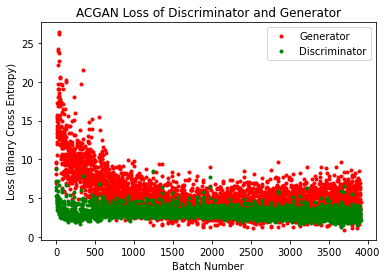

In [9]:
plt.plot(counter_list, gen_loss_list, 'r.', label='Generator')
plt.plot(counter_list, dis_loss_list, 'g.', label='Discriminator')
plt.title("ACGAN Loss of Discriminator and Generator")
plt.xlabel("Batch Number")
plt.ylabel("Loss (Binary Cross Entropy)")
plt.legend(loc="best")
plt.show()